<a href="https://colab.research.google.com/github/truongthuanr/self-project/blob/main/06_QA_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information

Reference: 
* [End-To-End Memory Networks](https://arxiv.org/pdf/1503.08895.pdf)

# import data

In [1]:
import numpy as np
import pickle

In [2]:
with open("/content/drive/MyDrive/01_Personal/01_Study/01_ML/04_QAChatBot/train_qa.txt", "rb") as f:
  train_data = pickle.load(f)

with open("/content/drive/MyDrive/01_Personal/01_Study/01_ML/04_QAChatBot/test_qa.txt", "rb") as f:
  test_data = pickle.load(f)

In [3]:
print(train_data[506][0])
print(train_data[506][1])
print(train_data[506][2])


['Daniel', 'took', 'the', 'milk', 'there', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Daniel', 'discarded', 'the', 'milk', '.', 'Mary', 'went', 'to', 'the', 'bathroom', '.']
['Is', 'Mary', 'in', 'the', 'bathroom', '?']
yes


In [4]:
all_data = train_data + test_data

In [5]:
len(train_data), len(test_data), len(all_data)

(10000, 1000, 11000)

In [6]:
vocab = set()

for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [7]:
vocab.add('no')
vocab.add('yes')

In [8]:
len(vocab)

37

In [9]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [10]:
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)
max_story_len

156

In [11]:
all_ques_lens = [len(data[1]) for data in all_data]
max_ques_len = max(all_ques_lens)
max_ques_len

6

# Vetorize data

In [12]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [14]:
tokenizer.word_index

{'.': 15,
 '?': 34,
 'apple': 37,
 'back': 9,
 'bathroom': 35,
 'bedroom': 13,
 'daniel': 8,
 'discarded': 31,
 'down': 14,
 'dropped': 25,
 'football': 6,
 'garden': 3,
 'got': 18,
 'grabbed': 7,
 'hallway': 10,
 'in': 28,
 'is': 23,
 'john': 4,
 'journeyed': 17,
 'kitchen': 27,
 'left': 5,
 'mary': 36,
 'milk': 20,
 'moved': 1,
 'no': 33,
 'office': 12,
 'picked': 30,
 'put': 24,
 'sandra': 21,
 'the': 22,
 'there': 29,
 'to': 16,
 'took': 19,
 'travelled': 2,
 'up': 32,
 'went': 26,
 'yes': 11}

In [15]:
train_story_text = []
train_ques_text = []
train_ans_text = []

In [16]:
for story,ques,ans in train_data:
  train_story_text.append(story)
  train_ques_text.append(ques)
  train_ans_text.append(ans)

In [17]:
train_story_text[0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [18]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [19]:
len(train_story_seq)

10000

In [20]:
train_story_seq[0]

[36, 1, 16, 22, 35, 15, 21, 17, 16, 22, 13, 15]

# Vectorization

In [21]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_ques_len):
  '''
  INPUT: 
  
  data: consisting of Stories,Queries,and Answers
  word_index: word index dictionary from tokenizer
  max_story_len: the length of the longest story (used for pad_sequences function)
  max_question_len: length of the longest question (used for pad_sequences function)


  OUTPUT:
  
  Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
  answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
  output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
  
  Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
  '''
  
  
  # X = STORIES
  X = []
  # Xq = QUERY/QUESTION
  Xq = []
  # Y = CORRECT ANSWER
  Y = []
  
  
  for story, query, answer in data:
      
      # Grab the word index for every word in story
      x = [word_index[word.lower()] for word in story]
      # Grab the word index for every word in query
      xq = [word_index[word.lower()] for word in query]
      
      # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
      # Index 0 is reserved so we're going to use + 1
      y = np.zeros(len(word_index) + 1)
      
      # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
      #
      y[word_index[answer]] = 1
      
      # Append each set of story,query, and answer to their respective holding lists
      X.append(x)
      Xq.append(xq)
      Y.append(y)
      
  # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
      
  # RETURN TUPLE FOR UNPACKING
  return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [22]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [23]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [24]:
inputs_test[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 36, 18, 22, 20, 29, 15,  4,  1, 16,
       22, 13, 15], dtype=int32)

In [25]:
inputs_train

array([[ 0,  0,  0, ..., 22, 13, 15],
       [ 0,  0,  0, ..., 22, 10, 15],
       [ 0,  0,  0, ..., 22, 35, 15],
       ...,
       [ 0,  0,  0, ..., 22, 13, 15],
       [ 0,  0,  0, ..., 20, 29, 15],
       [ 0,  0,  0, ..., 37, 29, 15]], dtype=int32)

In [26]:
inputs_train.shape

(10000, 156)

In [27]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
answers_test.shape

(1000, 38)

In [29]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.

In [30]:
input_sequence = Input((max_story_len,))
question = Input((max_ques_len,))

In [31]:
vocab_size = len(vocab) + 1

### Input Encorder m

In [32]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

### Input Encorder c

In [35]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

### Question encoder

In [37]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

### Encode the Sequences

In [39]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

Use dot product to compute the match between first input vector seq and the query

In [40]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

Add this match matrix with the second input vector sequence

In [41]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

Concatenate

In [42]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [43]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [44]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [45]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [46]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [48]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 8s 17ms/step - loss: 0.9246 - accuracy: 0.4911 - val_loss: 0.6968 - val_accuracy: 0.5030
Epoch 2/120
313/313 [==============================] - 5s 15ms/step - loss: 0.7050 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6959 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4910
Epoch 4/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6949 - accuracy: 0.4974 - val_loss: 0.6956 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6948 - accuracy: 0.4936 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6948 - accuracy: 0.5019 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 5s 15ms/step - loss: 0.6948 - accuracy: 0.4883 - val_loss: 0.6934 - val_accuracy:

#### Saving model

In [50]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Evaluating the Model

Ploting out training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


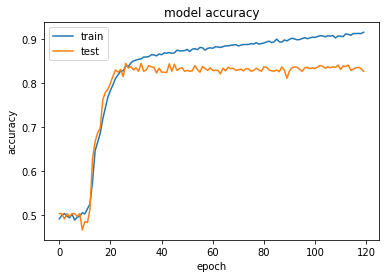

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate on givent test set

In [51]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [52]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [53]:
tory =' '.join(word for word in test_data[0][0])
print(story)

['Daniel', 'went', 'to', 'the', 'office', '.', 'Sandra', 'journeyed', 'to', 'the', 'hallway', '.', 'Daniel', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Mary', 'got', 'the', 'apple', 'there', '.', 'Sandra', 'moved', 'to', 'the', 'bathroom', '.', 'Mary', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'put', 'down', 'the', 'apple', 'there', '.', 'Sandra', 'got', 'the', 'milk', 'there', '.', 'Sandra', 'travelled', 'to', 'the', 'bedroom', '.', 'Sandra', 'took', 'the', 'apple', 'there', '.']


In [54]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [55]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [56]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99999166


# Using my own story and Question

In [61]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [62]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [63]:
my_question = "Is the football in the garden ?"
my_question.split()

In [68]:
mydata = [(my_story.split(),my_question.split(),"yes")]

In [69]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [70]:
pred_results = model.predict(([ my_story, my_ques]))

In [71]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.9971539
